In [1]:
!pip install sweetviz

In [2]:
import pandas as pd
import numpy as np

In [3]:
data = pd.read_csv ('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data')


In [4]:
data['is_above_50K'] = data[' <=50K'] == ' >50K'
cols = ['age', 
'workclass', 
'fnlwgt', 
'education', 
'education-num', 
'marital-status', 
'occupation', 
'relationship', 
'race', 
'sex', 
'capital-gain', 
'capital-loss', 
'hours-per-week', 
'native-country', '<=50k', 'is_above_50k'] 

data.columns = cols

In [5]:
!pip install plotly


In [6]:
import plotly.express as px

In [7]:
data['is_above_50k_int'] = np.where (data['is_above_50k'], 1, 0)

**Undersample the data**  
* Need to undersample the majority class to create realisistic links between independent variables.
* If not undersampled, this can lead to majority class over-representing a group that is contributing to the income 
NOTE: explore different ways, such representing data as a ratio

In [8]:
sample_df = data[['education', 	'age', 'sex', 'is_above_50k_int']]
sample_df[sample_df['is_above_50k_int'] == 0].shape

(24719, 4)

In [9]:
sample_df

education  age      sex  is_above_50k_int
0        Bachelors   50     Male                 0
1          HS-grad   38     Male                 0
2             11th   53     Male                 0
3        Bachelors   28   Female                 0
4          Masters   37   Female                 0
...            ...  ...      ...               ...
32555   Assoc-acdm   27   Female                 0
32556      HS-grad   40     Male                 1
32557      HS-grad   58   Female                 0
32558      HS-grad   22     Male                 0
32559      HS-grad   52   Female                 1

[32560 rows x 4 columns]

In [10]:
num_sample = sample_df[sample_df['is_above_50k_int'] == 1].shape[0]

In [11]:
below_50k_df = sample_df[sample_df['is_above_50k_int'] == 0].sample (n=num_sample)
above_50k_df = sample_df[sample_df['is_above_50k_int'] == 1]
data_df = pd.concat ((above_50k_df, below_50k_df))


* According to the plot, higher education contributes strongly to the likelyhood of income over 50K
* Split Ed into 2 groups Bachelors and above and below Bacherlors

In [12]:
parallel_set_df = data_df[['education', 	'age', 'sex', 'is_above_50k_int']].groupby(['education', 	'age', 'sex']).count().reset_index()
parallel_set_df['ED_is_Bachelors_Or_Higher'] = parallel_set_df['education'].apply (lambda x: x in set ([' Bachelors', ' Doctorate', ' Masters', ' Prof-school']))

In [13]:
parallel_set_df['ED_is_Bachelors_Or_Higher'] = parallel_set_df['education'].apply (lambda x: x in set ([' Bachelors', ' Doctorate', ' Masters', ' Prof-school']))

In [14]:
parallel_set_df[parallel_set_df['ED_is_Bachelors_Or_Higher'] == True].shape[0]

383

It looks like there is strong correlation between people between ages 35 and 65 and probability to be above 50K

In [15]:
parallel_set_df['age_btw_35_and_65'] = parallel_set_df['age'].apply (lambda x: (x >= 35) & (x<= 65)  )
parallel_set_df = parallel_set_df[['ED_is_Bachelors_Or_Higher', 'age_btw_35_and_65', 'sex','is_above_50k_int']].drop_duplicates()

In [16]:
fig = px.parallel_categories (parallel_set_df, dimensions=['ED_is_Bachelors_Or_Higher', 'age_btw_35_and_65', 'sex'], color='is_above_50k_int', color_continuous_scale=px.colors.sequential.Inferno)


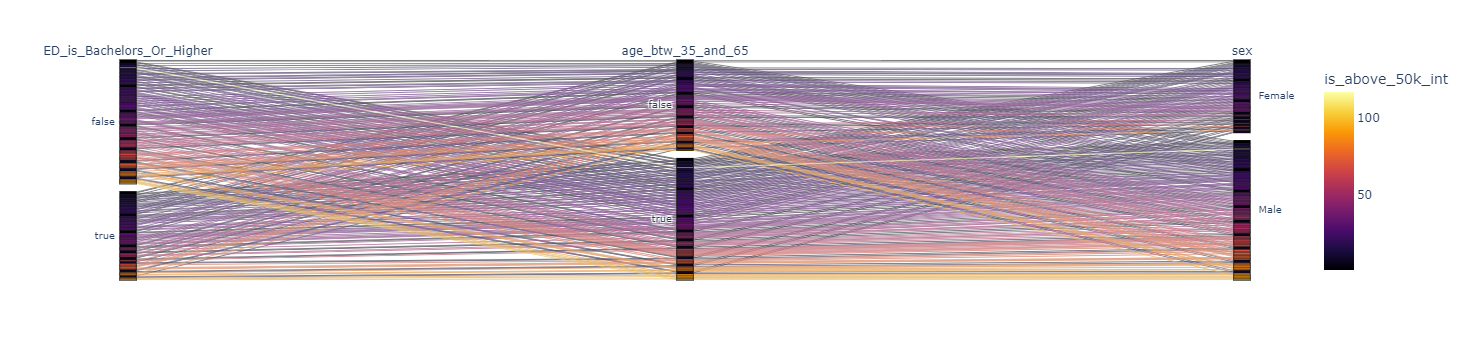

In [17]:
fig.show()

In [18]:
fig.write_html("parallel_categories_plot.html")

In [ ]:
import pandas as pd

In [ ]:
data.head()

In [ ]:

data['age'].describe()

In [ ]:
cats = pd.cut(data['age'], 9, labels=list (range (10, 100, 10)))

In [ ]:
age_buckets = cats.value_counts().reset_index()

In [ ]:
age_buckets

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
cats_df = cats.to_frame().rename(columns={'age': 'age_cat'})
data = pd.concat ((data, cats_df), axis=1)

In [ ]:
prob_above_50k_by_age_cat_df = data[['age_cat', 'is_above_50k_int']].groupby('age_cat').sum() / data[['age_cat', 'is_above_50k_int']].groupby('age_cat').count()
prob_above_50k_by_age_cat_df = prob_above_50k_by_age_cat_df.reset_index().rename(columns={'is_above_50k_int': 'prob_above_50k'})

count_by_age_cat_df = data[['age_cat', 'is_above_50k_int']].groupby('age_cat').count().reset_index().rename(columns={'is_above_50k_int': 'count'})
age_cat_prob_over_50k_df = pd.merge (count_by_age_cat_df, prob_above_50k_by_age_cat_df, on='age_cat')
age_cat_prob_over_50k_df['count_prob'] = age_cat_prob_over_50k_df['count'] / age_cat_prob_over_50k_df['count'].sum()

In [25]:
cat_types = ['object', 'str']
is_categorical = lambda cat: len ( [tp for tp in cat_types if cat == tp]) > 0

In [30]:
'''
cat column - category column that represents category in population. 
 - Only works for categorical variables
'''
def compute_prob_by_category(df: pd.DataFrame, cat_col: str, binary_target_col='is_above_50k_int'):
  if (is_categorical (df.dtypes[cat_col])):
    target_col_prob = f'prob_{binary_target_col}'
    count_prob = 'count_prob'
    columns = [cat_col, target_col_prob, count_prob]
    
    #calculate probability that cat_col is part of the group
    prob_df = df[[cat_col, binary_target_col]].groupby(cat_col).sum() / df[[cat_col, binary_target_col]].groupby(cat_col).count()
    prob_df = prob_df.reset_index().rename(columns={binary_target_col: \
                                                    f'prob_{binary_target_col}'})

    #calculate probability that each category occurs in the distribution for column group
    prob_each_cat_df = df[[cat_col, binary_target_col]].groupby(cat_col).count().reset_index().rename(columns={binary_target_col: 'count'})
    prob_each_cat_df['count_prob'] = prob_each_cat_df['count'] / prob_each_cat_df['count'].sum()
    #merge
    merge_df = pd.merge (prob_df, prob_each_cat_df, on=cat_col)
    return merge_df[columns]
  else:
    raise Exception ("Please provide categorical variable.")
  


Which types are categorical only

In [ ]:
[col for col in list (data.columns) if is_categorical(data.dtypes[col]) and col != '<=50k']

In [ ]:
marital_status_prob_df = compute_prob_by_category (data, 'marital-status')

In [ ]:
marital_status_prob_df.columns

In [ ]:
import plotly; plotly.__version__

In [21]:
import plotly.graph_objects as go
def plot_prob_histogram (df: pd.DataFrame, cat_col: str, binary_target_col='prob_is_above_50k_int'):
  '''
  Plot categorical variables and their probability of occurence in target
  '''
  x_line = list (df[cat_col])
  y_line = list (df[binary_target_col])
  x_bar = x_line
  y_bar = list (df['count_prob'])
  fig = go.Figure()
  fig.add_trace (go.Scatter (x=x_line, y=y_line, name='Probability > 50K'))
  fig.add_trace (go.Bar (x=x_bar, y=y_bar, name=cat_col))
  fig.show()
  fig.write_html(f"{cat_col}_with_prob_over_50k.html")

In [ ]:
plot_prob_histogram (marital_status_prob_df, 'marital-status')

In [24]:
def analyze (df, col:str):
  result_df = compute_prob_by_category (df, col)
  plot_prob_histogram (result_df, col)

In [28]:
cat_columns = [col for col in list (data.columns) if is_categorical(data.dtypes[col]) and col != '<=50k']

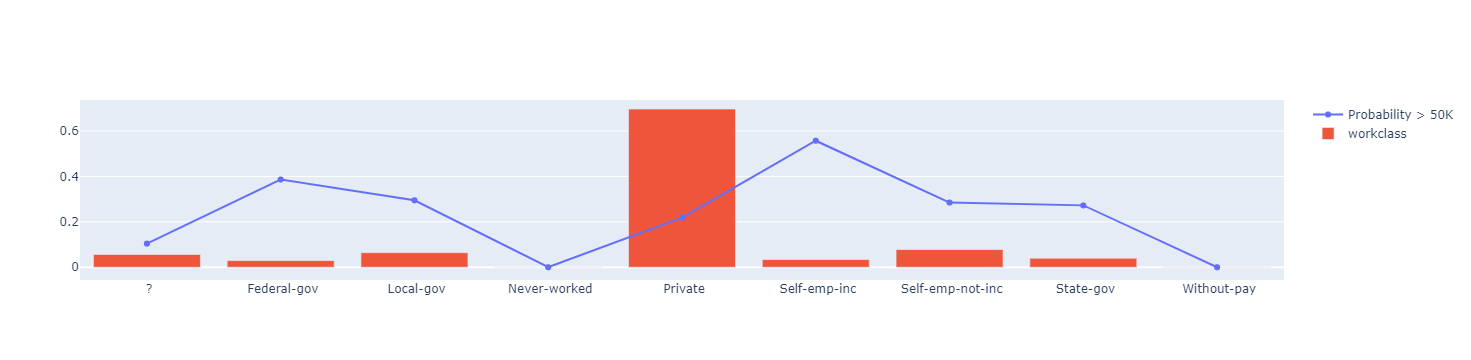

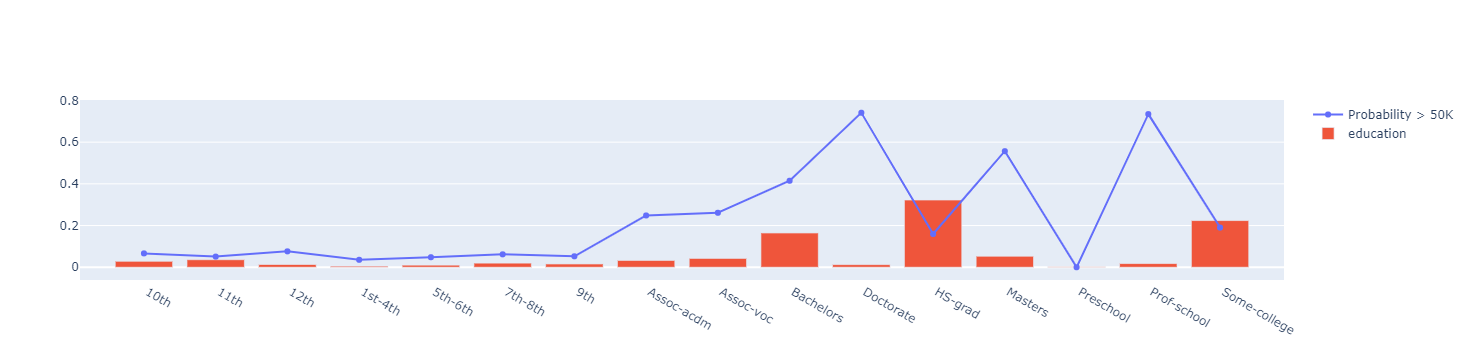

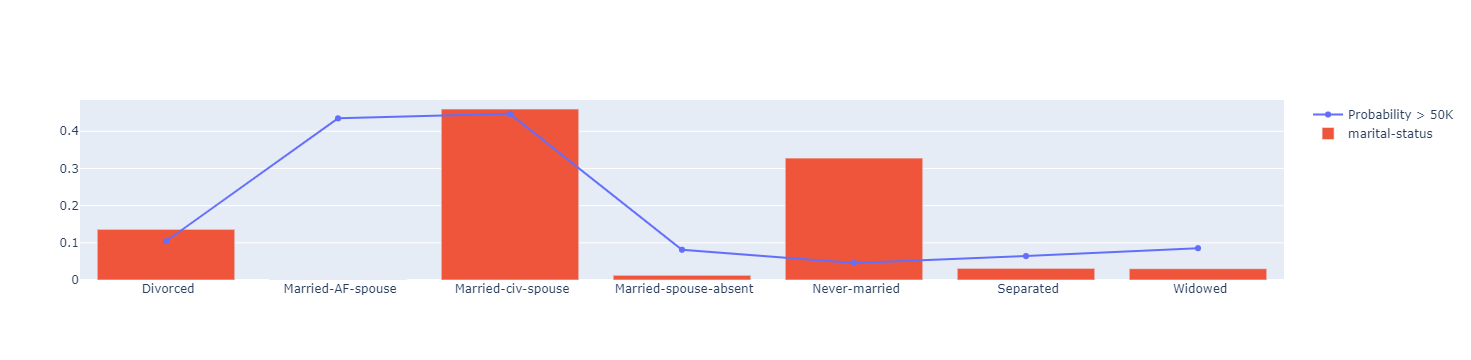

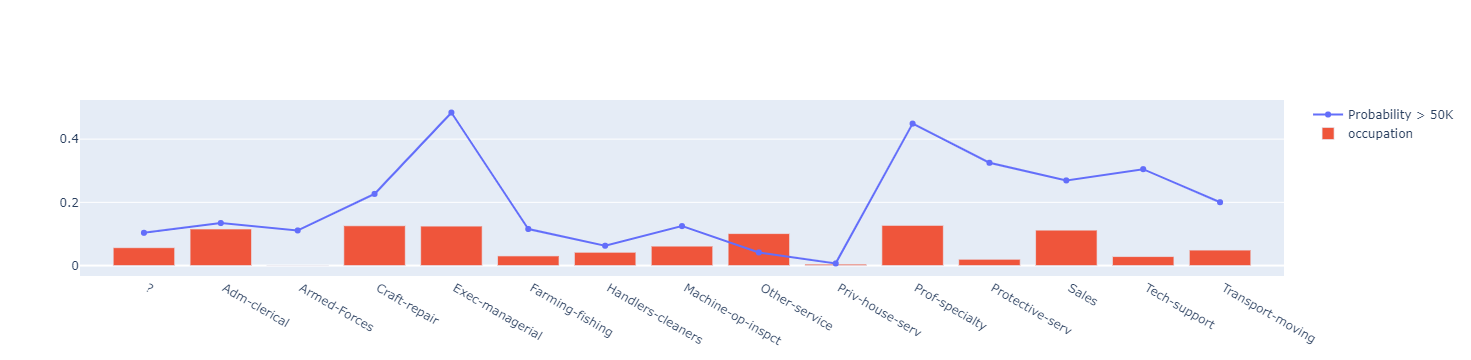

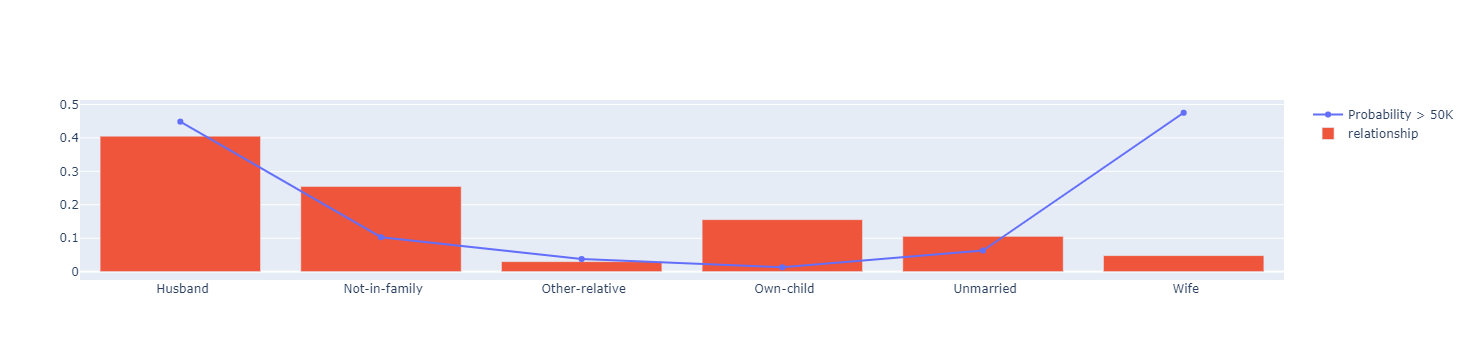

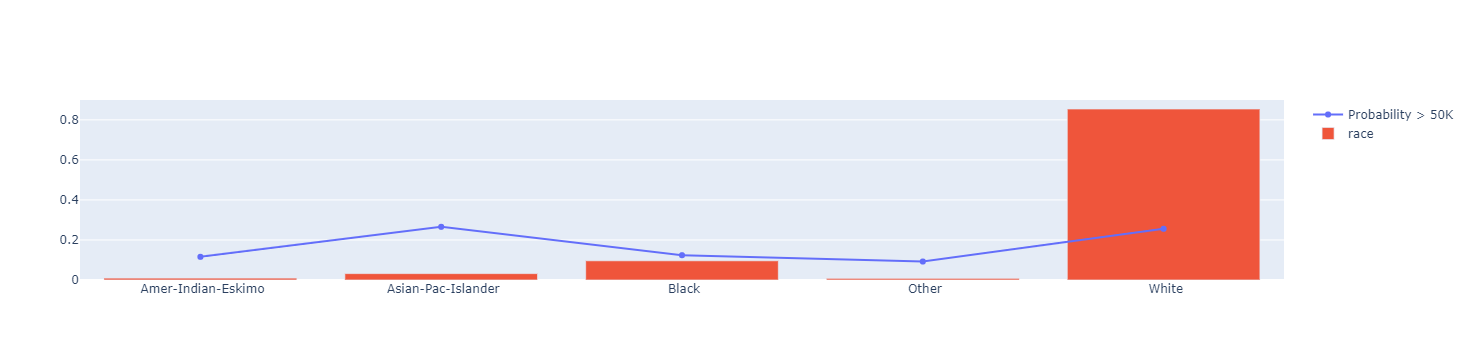

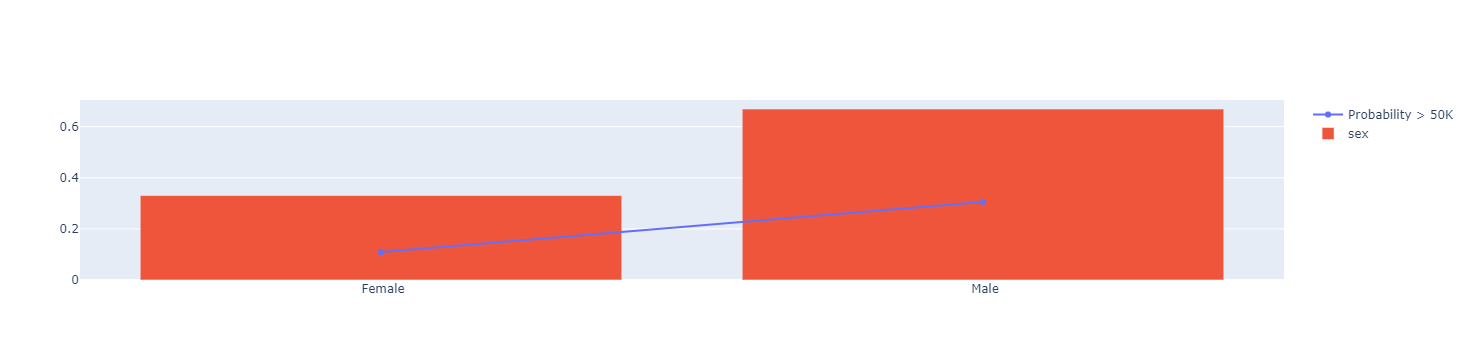

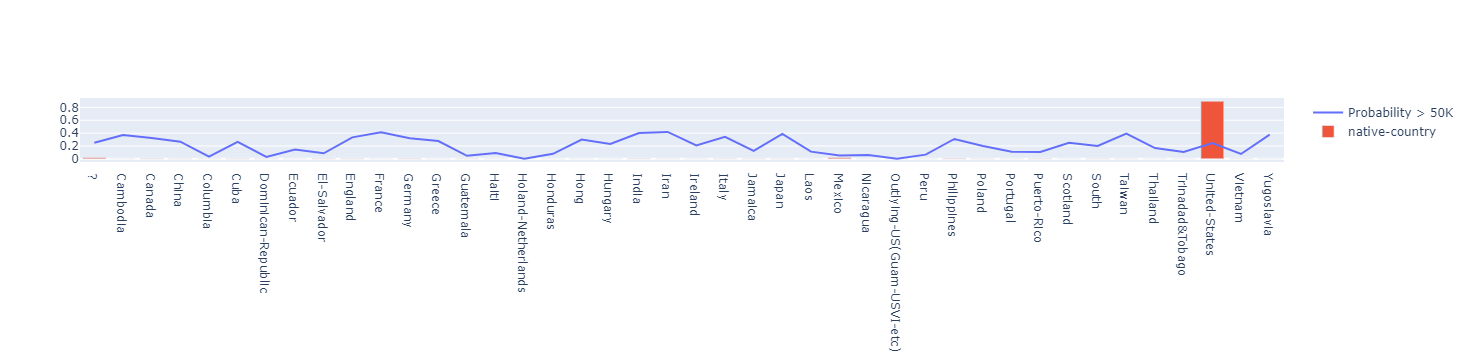

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
dtype: object

In [31]:
pd.Series (cat_columns).apply (lambda cat: analyze (data, cat))